In [1]:
from general import *
from exp1 import *
from exp2 import *
import time
import copy

random_state=42
np.random.seed(random_state)

## Experiment 

In [2]:
states=['ca','il','mo','tx']
labels = ['California','Illinois','Missouri','Texas']
alpha=.05
loss='mae'
colors=['#EB9846', '#12B8EB', '#773BEB', '#2F58EB', '#808080']
B=100
n_vals=20

In [3]:
data = pd.read_csv('data/car-insurance-public/data/mo-per-zip.csv')
data.head()

,zipcode,minority,companies_name,name,bi_policy_premium,pd_policy_premium,state_risk,white_non_hisp_pct,risk_difference,combined_premium
0,63005,False,21st Century Centennial Ins Co,FARMERS INS GRP,321,211.0,216.029693,87.9,315.970307,532.0
1,63010,False,21st Century Centennial Ins Co,FARMERS INS GRP,342,192.0,251.359806,93.9,282.640194,534.0
2,63011,False,21st Century Centennial Ins Co,FARMERS INS GRP,321,211.0,225.421778,88.9,306.578222,532.0
3,63012,False,21st Century Centennial Ins Co,FARMERS INS GRP,342,192.0,210.286312,97.2,323.713688,534.0
4,63013,False,21st Century Centennial Ins Co,FARMERS INS GRP,317,141.0,158.592140,100.0,299.407860,458.0


In [4]:
pvals=[]
times=[]

for s in tqdm(states):
    data = pd.read_csv('data/car-insurance-public/data/' + s + '-per-zip.csv')

    Z = np.array(data.state_risk).reshape((-1,1))
    Y = np.array(data.combined_premium).reshape((-1,1))
    X = (1*np.array(data.minority)).reshape((-1,1))
    
    Y_ci = Y #100+Z-(Z/5)**2
    X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y_ci, Z, test_size=.2, random_state=random_state)

    
    ###Fitting models
    g1 = g()
    g1.fit(X_train, Z_train, Y_train)
    g2 = g()
    g2.fit(None, Z_train, Y_train)
    g3 = g()
    g3.fit(None, Z_train, X_train)
    
    ###RBPT
    start_time = time.time()
    p = LogisticRegression().fit(Z_train, X_train.squeeze())
    H_test = np.sum(p.predict_proba(Z_test)*np.hstack((g1.predict(np.zeros(X_test.shape),Z_test).reshape(-1,1),
                                                       g1.predict(np.ones(X_test.shape),Z_test).reshape(-1,1))), axis=1).reshape(-1,1)
    pval_rbpt = get_pval_rbpt(X_test, Z_test, Y_test, H_test, g1, loss=loss)
    time_rbpt = time.time() - start_time

    ###RBPT2
    start_time = time.time()
    h = get_h(Z_train, g1.predict(X_train,Z_train).squeeze())
    pval_rbpt2 = get_pval_rbpt2(X_test, Z_test, Y_test, g1, h, loss=loss)
    time_rbpt2 = time.time() - start_time
    
    ###STFR
    start_time = time.time()
    pval_stfr = get_pval_stfr(X_test, Z_test, Y_test, g1, g2, loss=loss)
    time_stfr = time.time() - start_time
    
    ###RESIT
    start_time = time.time()
    pval_resit = get_pval_resit(X_test, Z_test, Y_test, g2, g3, B=B) 
    time_resit = time.time() - start_time
    
    ###GCM
    start_time = time.time()
    pval_gcm = get_pval_gcm(X_test, Z_test, Y_test, g2, g3) 
    time_gcm = time.time() - start_time
    
    ###Storing
    times.append([time_rbpt, time_rbpt2, time_stfr, time_resit, time_gcm])
    pvals.append([pval_rbpt, pval_rbpt2, pval_stfr, pval_resit, pval_gcm])
    
pvals=np.array(pvals)

100%|█████████████████████████████████████████████| 4/4 [00:19<00:00,  4.84s/it]


In [5]:
np.array(times).mean(axis=0)

array([3.92812490e-02, 3.69461554e+00, 4.62472439e-04, 1.04120547e+00,
       4.77612019e-04])

In [6]:
pvals_rbpt = pvals[:,0]
pvals_rbpt2 = pvals[:,1]
pvals_stfr = pvals[:,2]
pvals_resit = pvals[:,3]
pvals_gcm = pvals[:,4]

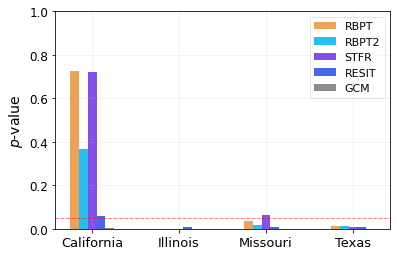

In [7]:
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

rects1 = plt.bar(x - width*2/3, pvals_rbpt, width/3, label='RBPT', color=colors[0], alpha=.9)
rects2 = plt.bar(x - width/3, pvals_rbpt2, width/3, label='RBPT2', color=colors[1], alpha=.9)
rects3 = plt.bar(x, pvals_stfr, width/3, label='STFR', color=colors[2], alpha=.9)
rects4 = plt.bar(x + width/3, pvals_resit, width/3, label='RESIT', color=colors[3], alpha=.9)
rects5 = plt.bar(x + width*2/3, pvals_gcm, width/3, label='GCM', color=colors[4], alpha=.9)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('$p$-value', size=14)
plt.xticks(x, labels, fontsize=13)
plt.legend(framealpha=0.5, prop={'size': 11}) 
plt.axhline(y=alpha, color='r', linestyle='--', lw=1, alpha=.5)
plt.yticks(fontsize=12)
plt.ylim(0,1)
plt.grid(alpha=.2)

#plt.savefig('plots/exp2_{:}.png'.format(loss), bbox_inches='tight', dpi=300, transparent=True)
plt.show()